<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_praca_domowa_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------
#1.Importowanie bibliotek i ustawienia parametrów symulacji
-----------------------------

In [52]:
# Importujemy potrzebne biblioteki
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# Ustawienia symulacji

n_features = 100         # liczba predyktorów
n_nonzero = 5           # liczba niezerowych współczynników
n_train = 100           # liczba obserwacji w zbiorze treningowym
n_test = 200            # liczba obserwacji w zbiorze testowym
sigma = 1.0             # odchylenie standardowe szumu

----------------------------------------
# 2. Wygenerowanie wektora znanych współczynników β oraz syntetycznego zbioru danych testowych
----------------------------------------

In [53]:
# Generujemy prawdziwe współczynniki: pierwsze n_nonzero losowe, reszta 0
beta_true = np.zeros(n_features)
beta_true[:n_nonzero] = np.random.uniform(1, 3, n_nonzero) * np.random.choice([-1, 1], n_nonzero)

# Funkcja generująca dane – obserwacje i etykiety
def generate_data(n_samples, n_features, beta, sigma):
    X = np.random.uniform(-1, 1, size=(n_samples, n_features))
    # Funkcja deterministyczna (bez szumu)
    y_true = X.dot(beta)
    # Dodajemy szum
    noise = np.random.normal(0, sigma, n_samples)
    y = y_true + noise
    return X, y, y_true

# Geberujemy zbiór testowy, który pozostanie stały w symulacjach
X_test, y_test, y_test_true = generate_data(n_test, n_features, beta_true, sigma)

----------------------------------
# 3. Wygenerowanie siatki wartości λ i przeprowadzenie regresji Lasso oraz Ridge
---------------------------------

In [58]:
# Siatka wartości λ
lambdas = np.logspace(-3, 3, 300)  # od bardzo małych do dużych wartości

# Liczba symulacji
n_simulations = 100

# Funkcja, która dla danego modelu (Ridge lub Lasso) i λ obliczy bias², wariancję oraz MSE
def simulate_model(model_class, lambdas, n_simulations, n_train, X_test, y_test_true, beta_true, sigma):
    n_lambdas = len(lambdas)
    bias2_arr = np.empty(n_lambdas)
    variance_arr = np.empty(n_lambdas)
    mse_arr = np.empty(n_lambdas)

    # Dla każdej wartości λ
    for i, lam in enumerate(lambdas):
        preds = np.empty((n_simulations, X_test.shape[0]))
        for sim in range(n_simulations):
            # Generujemy zbiór treningowy
            X_train, y_train, _ = generate_data(n_train, n_features, beta_true, sigma)
            # Standaryzacja: dopasowujemy StandardScaler do zbioru treningowego,
            # a następnie transformujemy zarówno X_train, jak i X_test
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Inicjalizacja modelu
            if model_class == Lasso:
                model = model_class(alpha=lam, max_iter=100000, fit_intercept=True, random_state=sim)
            else:
                model = model_class(alpha=lam, max_iter=100000, fit_intercept=True)
            model.fit(X_train_scaled, y_train)
            preds[sim] = model.predict(X_test_scaled)

        # Obliczamy średnią predykcję dla każdego punktu testowego
        mean_preds = preds.mean(axis=0)
        # Obliczamy bias jako różnicę między średnią predykcją a prawdziwą wartością funkcji (bez szumu)
        bias = mean_preds - y_test_true
        bias2_arr[i] = np.mean(bias ** 2)
        # Wariancja: średnia wariancja predykcji uzyskanych w symulacjach
        variance_arr[i] = np.mean(np.var(preds, axis=0))
        # MSE: średni błąd kwadratowy predykcji
        mse_arr[i] = np.mean((preds - y_test_true.reshape(1, -1)) ** 2)

    return bias2_arr, variance_arr, mse_arr

# Symulacja dla Ridge
ridge_bias2, ridge_variance, ridge_mse = simulate_model(Ridge, lambdas, n_simulations, n_train, X_test, y_test_true, beta_true, sigma)

# Symulacja dla Lasso
lasso_bias2, lasso_variance, lasso_mse = simulate_model(Lasso, lambdas, n_simulations, n_train, X_test, y_test_true, beta_true, sigma)


------------------------------------------------
# 4. Wykresy wyników bias², wariancji oraz MSE dla obu regresji

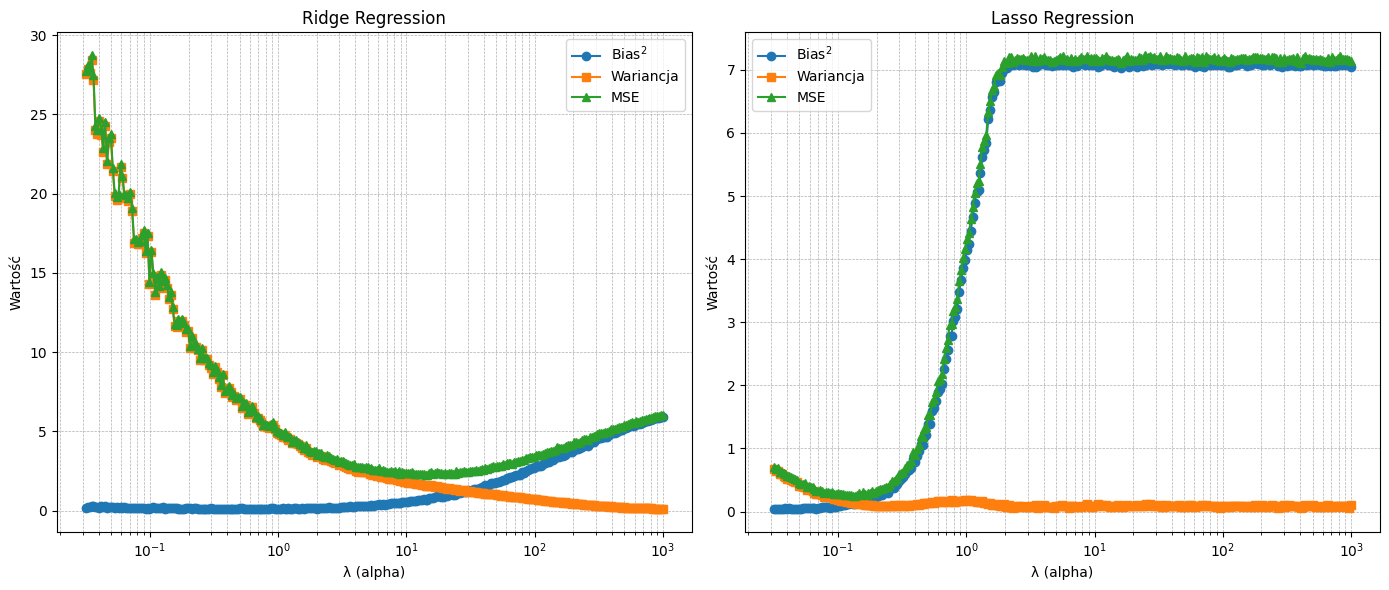

In [59]:
# Rysujemy wykresy Bias², wariancji i MSE dla obu modeli
plt.figure(figsize=(14, 6))

# Wykres dla Ridge
plt.subplot(1, 2, 1)
plt.semilogx(lambdas, ridge_bias2, label=r'Bias$^2$', marker='o')
plt.semilogx(lambdas, ridge_variance, label='Wariancja', marker='s')
plt.semilogx(lambdas, ridge_mse, label='MSE', marker='^')
plt.xlabel('λ (alpha)')
plt.ylabel('Wartość')
plt.title('Ridge Regression')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Wykres dla Lasso
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, lasso_bias2, label=r'Bias$^2$', marker='o')
plt.semilogx(lambdas, lasso_variance, label='Wariancja', marker='s')
plt.semilogx(lambdas, lasso_mse, label='MSE', marker='^')
plt.xlabel('λ (alpha)')
plt.ylabel('Wartość')
plt.title('Lasso Regression')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

------------------------------
#5. Odpowiedzi na pytania
------------------------------

----------------------------
## I. W jaki sposób zmiana parametru regularyzacji λ w regresji Ridge oraz Lasso wpływa na kompromis między bias a wariancją?

**Regresja Ridge**\
Z uzyskanego wykresu dla regresji Ridge możemy odczytać, że dla małych wartości λ model wykazuje niski bias, ale wysoką wariancję, gdyż model ma tendencję do dopasowania się mocno do danych treningowych. Wraz ze wzrostem λ model jest silniej „ściągany” w stronę mniejszych wartości współczynników. Bias rośnie, natomiast wariancja maleje (model staje się bardziej stabilny i mniej podatny na przeuczenie). Jednak dla bardzo dużych λ model może być zbyt prosty i niedouczać się, przez co bias jest bardzo wysoki.\
**Regresja Lasso**\
Mechanizm jest podobny co do wzajemnej zależności bias-wariancja dla regresji Ridge: im większa λ, tym wyższy bias i niższa wariancja. Jednak w odróżnieniu od Ridge, regresja Lasso dla większych λ stabilizuje wartość bias, co w połączeniu z bardzo niską wariancją powoduje, że  MSE staje się stałe.

------------------------------------------
#II.Wyjaśnij dekompozycję MSE na składniki bias i wariancja.

Średni błąd kwadratowy (MSE) dla estymatora $\hat{f}(x)$ można rozłożyć na dwa główne składniki – bias oraz wariancję – z dodatkowym stałym składnikiem związanym z szumem, czyli błędem nieusuwalnym. Matematycznie zapisujemy to następująco:
$$
\text{MSE} = \underbrace{\Big(\mathbb{E}[\hat{f}(x)] - f(x)\Big)^2}_{\text{bias}^2}
+ \underbrace{\mathbb{E}\Big[\Big(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\Big)^2\Big]}_{\text{wariancja}}
+ \sigma^2.
$$
gdzie:\
**Bias$^2$:** Jest to miara systematycznego błędu, określająca różnicę między średnią wartością prognozowaną przez model a rzeczywistą wartością funkcji $f(x)$. Wysoki bias oznacza, że model jest zbyt uproszczony i nie potrafi uchwycić istotnych zależności w danych.\
**Wariancja:** Mierzy, jak bardzo wyniki modelu zmieniają się przy różnych próbkach danych treningowych. Wysoka wariancja wskazuje, że model jest bardzo czuły na zmiany w danych, co może prowadzić do przeuczenia.\
**Błąd nieusuwalny (szum) $\sigma^2$:** Reprezentuje naturalną zmienność danych, której nie da się wyeliminować poprzez lepsze dopasowanie modelu.

------------------------------------------
#III. Czy regularyzacja prowadzi do istnienia optymalnego punktu kompromisu, w którym MSE jest minimalne? Wyjaśnij, dlaczego taki punkt istnieje.
Tak, regularyzacja prowadzi do istnienia optymalnego punktu na krzywej zależności MSE od λ, w którym MSE przyjmuje minimum. Widać to na wykresach, gdzie krzywa MSE ma kształt litery „U” lub spłaszczonego „U”.\
Dzieje się tak z powodu zależności opisanej w odpowiedzi na pytanie I. Dla małych λ bias jest mały, ale wariancja duża. Przy rosnącym λ bias rośnie, a wariancja maleje. Z tego wynika, że wykres MSE przyjmuje kształt "U" lub spłaszczonego "U", więc można wybrać parametr λ optymalny, dla którego dalsze zmniejszanie wariancji nie jest opłacalne ze względu na rosnący bias.


In [ ]:

# Obserwujemy, że przy bardzo małych wartościach λ model jest bardzo złożony – ma niski bias, ale wysoką wariancję.
# W miarę wzrostu λ bias wzrasta (model staje się zbyt uproszczony), natomiast wariancja maleje.
# Krzywa MSE (błąd średniokwadratowy) przyjmuje kształt litery "U" – istnieje punkt, w którym MSE jest minimalne.
#
# Dlaczego taki punkt istnieje? Regularyzacja (poprzez λ) wprowadza kompromis między bias a wariancją.
# Dla bardzo małych λ model nadmiernie dopasowuje się do szumu (niski bias, wysoka wariancja),
# a dla bardzo dużych λ model jest zbyt uproszczony (wysoki bias, niska wariancja).
# Punkt optymalny to taki, gdzie wzrost biasu dokładnie rekompensuje spadek wariancji, co minimalizuje MSE.
#
# Porównując Ridge i Lasso, zauważamy, że:
# - Lasso (norma ℓ1) może ścisle zerować nieistotne współczynniki, co prowadzi do oszczędności modelu (sparsity).
# - Ridge (norma ℓ2) kurczy współczynniki, ale nie eliminuje ich całkowicie.